In [1]:
import numpy as np
import pandas as pd
import librosa
from IPython.display import Audio, display
import IPython
import librosa.display

In [2]:
from glob import glob

filenames = glob('../input/subescobangla-speech-emotion-dataset/SUBESCO/*.wav')

labels = []
for each in filenames:
    each = each.split('/')[-1][:-3]
    labels.append(each.split('_')[-2])

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy
from scipy.io import wavfile
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [4]:
file = filenames[0]
data = [] # X


from tqdm import tqdm

# reading the files here

for file in tqdm(filenames):
    temp = scipy.io.wavfile.read(file, mmap=False)
    data.append(temp[1])

index = [] # y
for each in labels:
    index.append(list(np.unique(labels)).index('FEAR'))

100%|██████████| 7000/7000 [01:19<00:00, 88.46it/s]


In [5]:
len(data[0])

193376

SAD


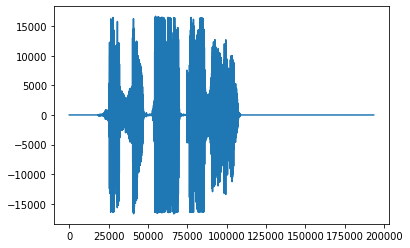

In [6]:
index = 5000
print(labels[index])
plt.plot(data[index])

IPython.display.Audio(filenames[index])

#একদিন পরেই তার বিয়ে :v 
# 

NEUTRAL


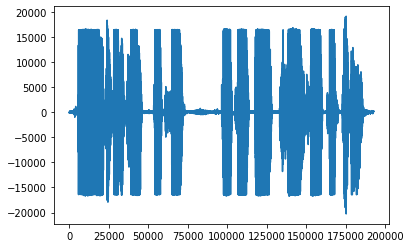

In [7]:
index = 5909
print(labels[index])
plt.plot(data[index])

IPython.display.Audio(filenames[index])
#মৌমাছির চাক দেখে কুকুরটি ঘেউ ঘেউ করছে

SURPRISE


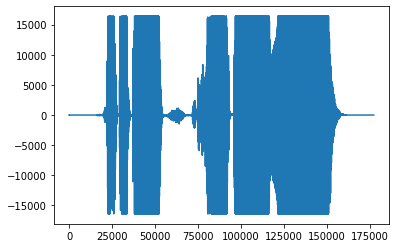

In [8]:
index = 5923
print(labels[index])
plt.plot(data[index])

IPython.display.Audio(filenames[index])
#ডাকাতেরা ঢাল তলোয়ার নিয়ে এলো

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


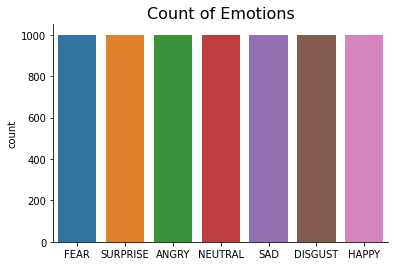

In [9]:
import seaborn as sns
plt.title('Count of Emotions', size=16)
sns.countplot(labels)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

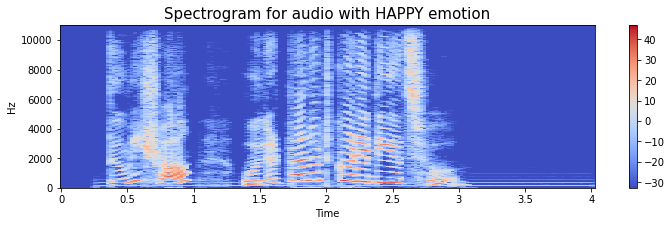

In [11]:
spectogram = []
idx = 39
#for idx in range(7000):
emotion=labels[idx]
path = filenames[idx]
data, sampling_rate = librosa.load(path)

a = create_spectrogram(data, sampling_rate, emotion)
    #Audio(path)
spectogram.append(a)

# **Data Augmentation**

In [12]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.

# index= 5908
# path = filenames[index]
# dataTemp, sample_rate = librosa.load(path)

Simple

HAPPY


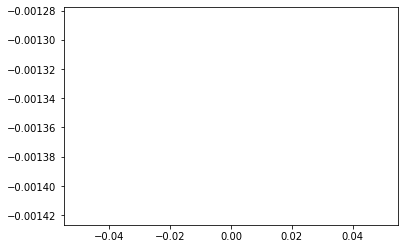

In [13]:
index = 5908
print(labels[index])
plt.plot(data[index])

IPython.display.Audio(filenames[index])
#সে কোন কিছু না বলেই চলে গেছে

SURPRISE


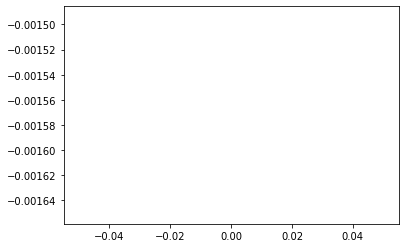

In [14]:
index = 5907
print(labels[index])
plt.plot(data[index])
plt.show()

IPython.display.Audio(filenames[index])
#তোমাকে এখনি আমার সাথে যেতে হবে

In [15]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result